# Brazil Yield Surface    # Curva Zero-Cupom BID - Bootstrapping + NSS

In [1]:
# ---------- imports ----------
import sys, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from calendars.daycounts import DayCounts
from finmath.termstructure.curve_models import CurveBootstrap, NelsonSiegelSvensson
from finmath.brazilian_bonds.corporate_bonds import CorpsCalcs1
from mpl_toolkits.mplot3d import Axes3D          # noqa: F401  (needed for 3-D)

from IPython.display import display
import plotly.graph_objects as go
import numpy as np
import pandas as pd


# ---------------------------------------------------------------

# ---------- static files & constants ----------
REPO_ROOT = Path.cwd()
while not (REPO_ROOT / ".git").exists() and REPO_ROOT != REPO_ROOT.parent:
    REPO_ROOT = REPO_ROOT.parent

SUPRA_PATH = REPO_ROOT / "datos_y_modelos" / "Domestic" / "supra.xlsx"
YIELD_PATH = Path("../db/supranational_bonds/ya.xlsx")
ID_COL = "id"     # change here if necessary
DAYCOUNT = DayCounts("bus/252", calendar="cdr_anbima")

IndentationError: unexpected indent (corporate_bonds.py, line 21)

In [ ]:
#──────────────────────────────────────────────────────────────────
#  2.  Static bond characteristics
#──────────────────────────────────────────────────────────────────
bonds_static = pd.read_excel(SUPRA_PATH)
bonds_static["MATURITY"]     = pd.to_datetime(bonds_static["MATURITY"])
bonds_static["FIRST_CPN_DT"] = pd.to_datetime(
    bonds_static["FIRST_CPN_DT"], errors="coerce"
)
bonds_static = bonds_static.dropna(subset=["MATURITY"])
bonds_static = bonds_static[bonds_static["MATURITY"] >= "2000-01-01"]
bonds_static = bonds_static.set_index(ID_COL)

In [ ]:
#──────────────────────────────────────────────────────────────────
#  3.  Historical yield matrix (ya_value_only sheet)
#──────────────────────────────────────────────────────────────────
ylds = pd.read_excel(YIELD_PATH, sheet_name="ya_values_only")
ylds.rename(columns={ylds.columns[0]: "OBS_DATE"}, inplace=True)
ylds["OBS_DATE"] = pd.to_datetime(ylds["OBS_DATE"])
ylds = ylds.set_index("OBS_DATE").sort_index()

In [ ]:
#──────────────────────────────────────────────────────────────────
#  4.  Helpers
#──────────────────────────────────────────────────────────────────
def clean_yield_series(y: pd.Series) -> pd.Series:
    """Return decimal yields with 0 < y < 40 % and finite."""
    y = pd.to_numeric(y, errors="coerce")
    return y.where((y > 0.0) & (y < 0.40))

def build_zero_curve(ref_date: pd.Timestamp, yld_row: pd.Series) -> pd.Series:
    """
    Bootstrap zero-curve for <ref_date>.
    Returns Series indexed by time-to-maturity (yrs) with DECIMAL rates.
    """
    df = bonds_static.copy()

    raw = df.index.to_series().map(yld_row) / 100.0        # % → decimal
    df["YAS_BOND_YLD"] = clean_yield_series(raw)

    df = df.dropna(subset=["YAS_BOND_YLD"])
    df = df[df["MATURITY"].dt.date > ref_date.date()]
    if len(df) < 5:
        raise ValueError("≤ 4 clean bonds")

    # split by coupon type
    zc_df    = df[df["CPN_TYP"] == "ZERO COUPON"].sort_values("MATURITY")
    fixed_df = df[df["CPN_TYP"] == "FIXED"].sort_values("MATURITY")

    # zero-coupon bonds
    zc_prices, zc_cf = [], []
    for mat, y in zip(zc_df["MATURITY"], zc_df["YAS_BOND_YLD"]):
        b = CorpsCalcs1(expiry=mat.date(), rate=y, ref_date=ref_date)
        zc_prices.append(b.price)
        zc_cf.append(pd.Series(index=[mat.date()], data=[b.principal]))

    # fixed-coupon bonds
    fixed_prices, fixed_cf = [], []
    for mat, y, cr, fq, fcd in zip(
        fixed_df["MATURITY"],
        fixed_df["YAS_BOND_YLD"],
        fixed_df["CPN"].astype(float) / 100.0,
        fixed_df["CPN_FREQ"].fillna(1).astype(int),
        fixed_df["FIRST_CPN_DT"],
    ):
        b = CorpsCalcs1(
            expiry=mat.date(),
            rate=y,
            coupon_rate=cr,
            freq=fq,
            ref_date=ref_date,
            first_coupon_date=fcd.date() if pd.notna(fcd) else None,
        )
        fixed_prices.append(b.price)
        fixed_cf.append(b.cash_flows)

    cb = CurveBootstrap(
        prices     = zc_prices  + fixed_prices,
        cash_flows = zc_cf      + fixed_cf,
        ref_date   = ref_date,
    )
    return cb.zero_curve            # Series (index = ttm, values = decimal)


In [ ]:

#──────────────────────────────────────────────────────────────────
#  5.  Build surface across all observation dates
#──────────────────────────────────────────────────────────────────
surface_rows = []
for obs_date, yld_row in ylds.iterrows():
    try:
        zero_curve = build_zero_curve(obs_date, yld_row)

        ttms = (
            [DAYCOUNT.tf(obs_date, d) for d in zero_curve.index]
            if np.issubdtype(zero_curve.index.dtype, np.datetime64)
            else zero_curve.index.astype(float)
        )

        surface_rows.append(
            pd.DataFrame(
                {"obs_date":  obs_date,
                 "ttm":       ttms,
                 "zero_rate": zero_curve.values * 100.0}   # -> percent
            )
        )
    except ValueError as err:
        #print(f"⚠️ {obs_date.date()} skipped ({err})")
        print(f"")

if not surface_rows:
    raise RuntimeError("No curves built – adjust filters")

surface = pd.concat(surface_rows, ignore_index=True)
print(f"Built curves for {surface['obs_date'].nunique()} observation dates.")









































































Built curves for 55 observation dates.


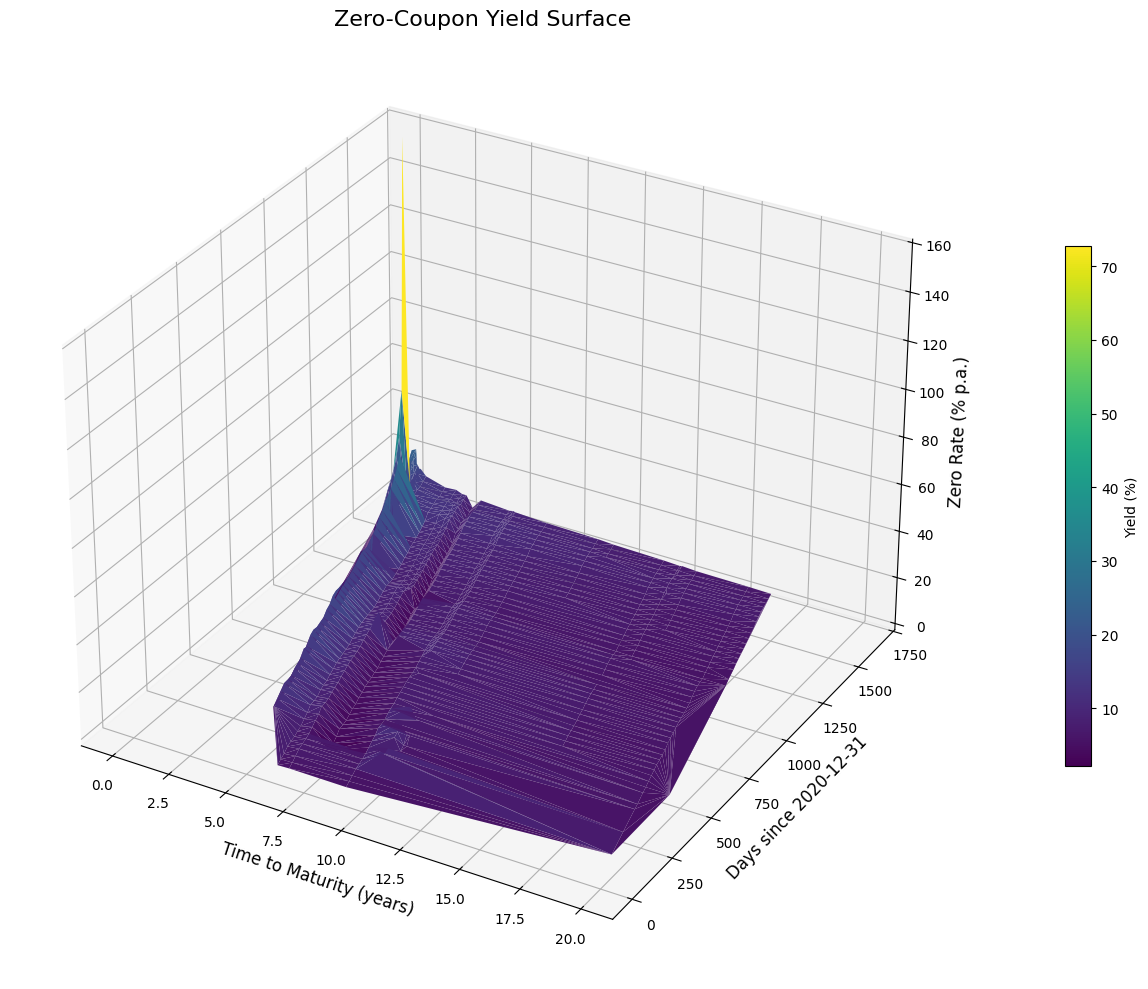

In [ ]:
#──────────────────────────────────────────────────────────────────
#  6.  Static 3-D surface plot
#──────────────────────────────────────────────────────────────────
obs0 = surface["obs_date"].min()
surface["obs_days"] = (surface["obs_date"] - obs0).dt.days

fig = plt.figure(figsize=(14, 10))
ax  = fig.add_subplot(111, projection="3d")
trisurf = ax.plot_trisurf(
    surface["ttm"],
    surface["obs_days"],
    surface["zero_rate"],
    cmap="viridis",
    linewidth=0.15,
)
ax.set_xlabel("Time to Maturity (years)", fontsize=12)
ax.set_ylabel(f"Days since {obs0.date()}", fontsize=12)
ax.set_zlabel("Zero Rate (% p.a.)", fontsize=12)
ax.set_title("Zero-Coupon Yield Surface", fontsize=16)
fig.colorbar(trisurf, shrink=0.55, pad=0.08, label="Yield (%)")
plt.tight_layout()
plt.show()

Grid after pruning → 55 dates × 655 maturities (700 data points)


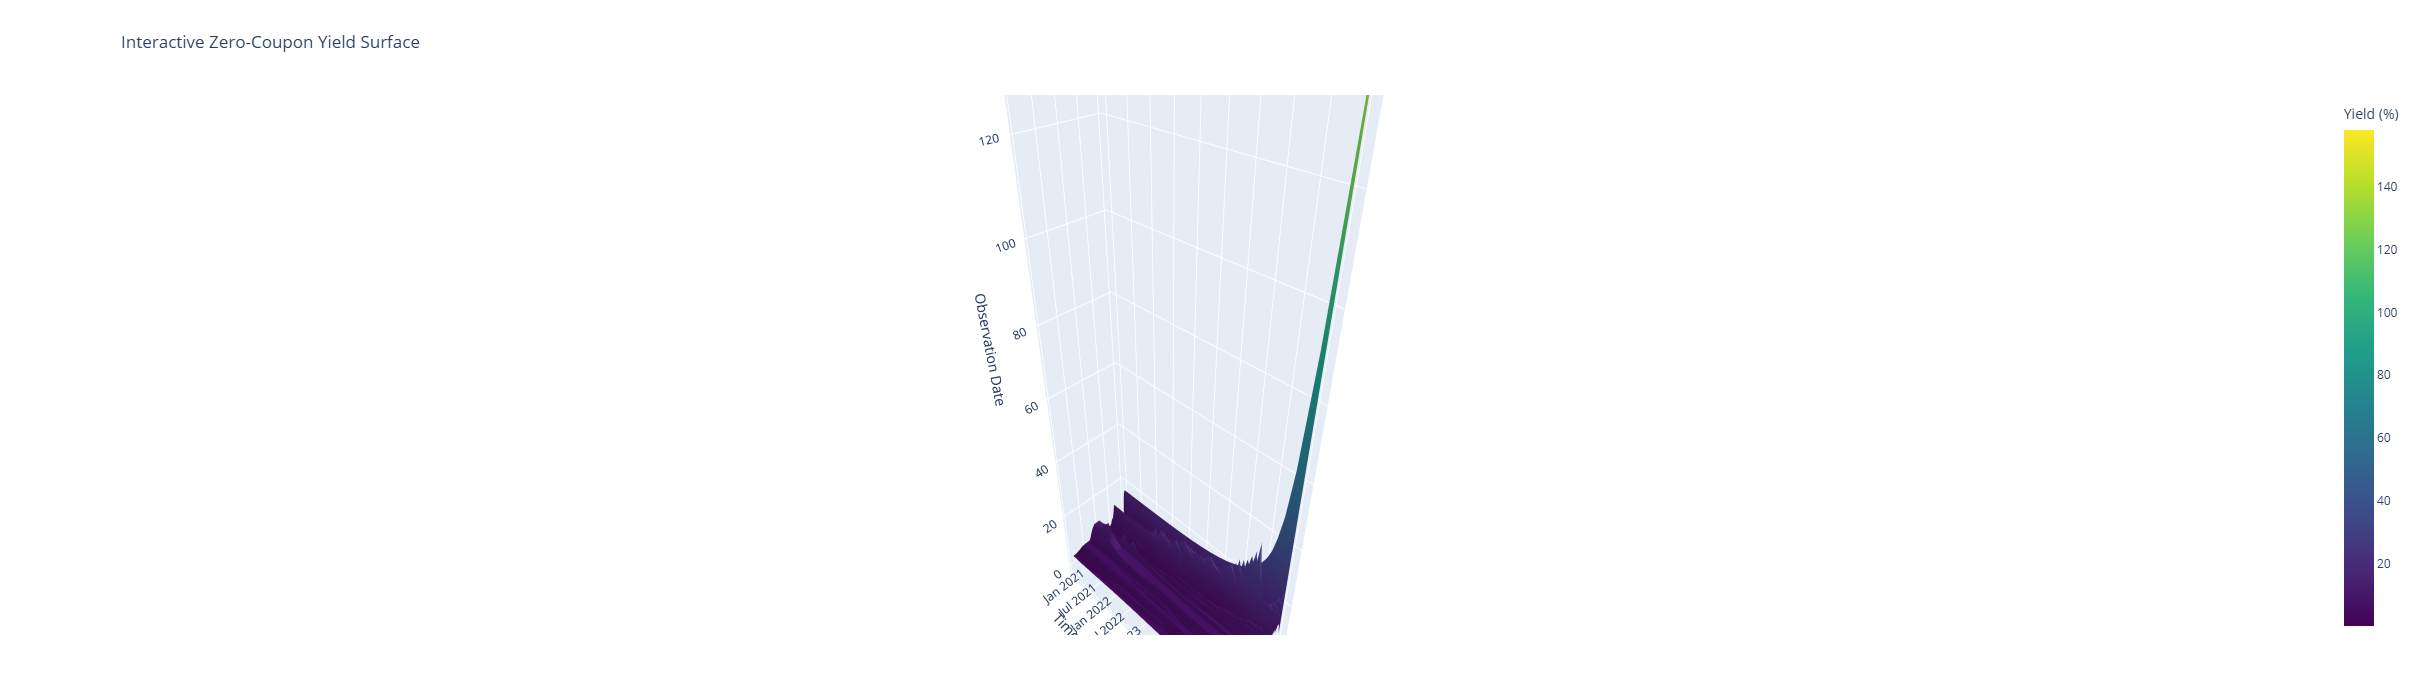

In [ ]:
#──────────────────────────────────────────────────────────────────
#  Plotly Interactive Zero-Curve Surface (robust & full)
#──────────────────────────────────────────────────────────────────

# 1️⃣Prepare clean grid ------------------------------------------------
dates_full = np.array(sorted(surface["obs_date"].unique()))
mats_full  = np.array(sorted({round(t, 4) for t in surface["ttm"]}))   # rounded keys

z_mat = np.full((len(dates_full), len(mats_full)), np.nan)

# populate grid
for i, d in enumerate(dates_full):
    df_day = surface[surface["obs_date"] == d]
    for _, r in df_day.iterrows():
        j = np.where(mats_full == round(r["ttm"], 4))[0][0]  # exact match after rounding
        z_mat[i, j] = r["zero_rate"]

# 2️⃣  Prune rows/cols that are entirely NaN ------------------------------
row_keep = (~np.isnan(z_mat)).any(axis=1)
col_keep = (~np.isnan(z_mat)).any(axis=0)

z_keep     = z_mat[row_keep][:, col_keep]
dates_keep = dates_full[row_keep]
mats_keep  = mats_full[col_keep]

print(f"Grid after pruning → {z_keep.shape[0]} dates × {z_keep.shape[1]} maturities "
      f"({np.isfinite(z_keep).sum()} data points)")

# 3️⃣  Build interactive surface -----------------------------------------
fig = go.Figure(
    data = [go.Surface(
        z              = z_keep,
        x              = mats_keep,                           # Time-to-maturity (yrs)
        y              = pd.to_datetime(dates_keep).strftime('%Y-%m-%d'),  # Dates
        colorscale     = 'Viridis',
        colorbar_title = "Yield (%)",
        connectgaps    = True,
        hovertemplate  =
            "TTM: %{x:.2f} yrs<br>" +
            "Date: %{y}<br>" +
            "Yield: %{z:.2f}%<extra></extra>",
    )]
)

fig.update_layout(
    title   = "Interactive Zero-Coupon Yield Surface",
    autosize= True,
    height  = 700,
    scene   = dict(
        yaxis_title = 'Time to Maturity (years)',
        zaxis_title = 'Observation Date',
        xaxis_title = 'Zero Rate (% p.a.)',
        aspectmode  = 'data',        # <- keeps real proportions
        yaxis       = dict(nticks=min(10, len(mats_keep))),
        zaxis       = dict(nticks=min(10, len(dates_keep))),
        xaxis       = dict(nticks=8),
    ),
    margin  = dict(l=50, r=50, b=65, t=95),
)
            
fig.show()

In [ ]:
#──────────────────────────────────────────────────────────────────
#  7.  Tables of data *used* to build the chart
#──────────────────────────────────────────────────────────────────
# -- observed inputs (cleaned yields, %)
dates_used      = surface["obs_date"].unique()
common_tickers  = list(set(bonds_static.index) & set(ylds.columns))

inputs_used = (
    ylds.loc[dates_used, common_tickers]          # raw % matrix slice
        .apply(pd.to_numeric, errors="coerce")
        .where(lambda df: (df > 0) & (df < 40))  # same cleaning band
        .dropna(how="all", axis=1)
        .sort_index()
        .round(4)
)

# -- zero-curve outputs (surface values, %)
outputs_zero = (
    surface
        .pivot_table(index="obs_date",
                     columns="ttm",
                     values="zero_rate",
                     aggfunc="mean")
        .round(4)
)
outputs_zero.columns = [f"{c:.2f}" for c in outputs_zero.columns]

print("\n▶ OBSERVED INPUTS (yields, %)")
display(inputs_used)

print("\n▶ ZERO-CURVE OUTPUTS (% p.a.)")
display(outputs_zero)

#──────────────────────────────────────────────────────────────────
#  (Optional) save to CSV for external use
#──────────────────────────────────────────────────────────────────
# inputs_used.to_csv("observed_inputs.csv")
# outputs_zero.to_csv("zero_curve_surface.csv")



▶ OBSERVED INPUTS (yields, %)


,AX813975 Corp,ZM636659 Corp,YS509089 Corp,YU254355 Corp,BN756935 Corp,BO165590 Corp,BT482185 Corp,AZ257187 Corp,ZM903300 Corp,ZL641942 Corp,...,ZH598780 Corp,BT802365 Corp,BQ376842 Corp,YS542553 Corp,BP322887 Corp,BT642376 Corp,ZH961035 Corp,ZJ582077 Corp,BU614742 Corp,YW833064 Corp
OBS_DATE,,,,,,,,,,,,,,,,,,,,,
2020-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.6341,NaN,NaN
2021-01-29,5.9466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.2620,NaN,NaN
2021-02-26,6.6197,NaN,NaN,NaN,6.5620,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0925,NaN,NaN
2021-03-31,7.7537,NaN,NaN,NaN,7.4926,8.2406,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,17.8830,NaN,NaN,22.9052,NaN,NaN
2021-04-30,7.4594,NaN,NaN,NaN,7.0886,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,16.8541,NaN,NaN,21.8452,NaN,NaN
2021-05-31,7.6683,NaN,NaN,NaN,7.0065,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,13.9159,NaN,NaN,21.4327,NaN,NaN
2021-06-30,7.6546,NaN,NaN,NaN,7.4294,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,14.1367,NaN,NaN,21.3933,NaN,NaN
2021-07-30,8.1658,NaN,NaN,NaN,7.6852,8.4632,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,14.2145,NaN,NaN,21.6645,NaN,NaN
2021-08-31,8.7366,NaN,NaN,NaN,8.5349,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,14.7509,NaN,NaN,23.0736,NaN,NaN



▶ ZERO-CURVE OUTPUTS (% p.a.)


,0.05,0.13,0.21,0.25,0.29,0.33,0.35,0.37,0.41,0.42,...,18.60,18.68,18.77,18.85,18.93,19.09,19.18,19.51,19.84,19.85
obs_date,,,,,,,,,,,,,,,,,,,,,
2020-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-02-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0142
2021-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.1351,NaN,NaN
2021-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
